# Import main libraries 

In [ ]:
# The causalTree package is not in CRAN, the most common R repository.
# To install it, uncomment the next lines as appropriate.

# install.packages("devtools")  # if you don't have this installed yet.
# devtools::install_github('susanathey/causalTree') 

In [1]:
library(causalTree)
# use e.g., install.packages("grf") to install any of the following packages.
library(grf)
library(rpart)
library(glmnet)
library(splines)
library(MASS)
library(lmtest)
library(sandwich)
library(ggplot2)
library(haven)
library(fastDummies)
library(tidyverse)

Loading required package: rpart

Loading required package: rpart.plot

Loading required package: data.table

Loading required package: Matrix

Loaded glmnet 4.1-4

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v tibble  3.1.6     v dplyr   1.0.8
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1
v purrr   0.3.4     

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::between()   masks data.table::between()
x tidyr::expand()    masks Matrix::expand()
x dplyr::filter()    masks stats::filter()
x dplyr::first()     masks data.table::first()
x dplyr::lag()       masks stats::lag()
x dplyr::last()      masks data.table::last()
x tidyr::pack()      masks Matrix::pack()
x dplyr

In [2]:
# Load required packages for this tutorial
library(DoubleML)
library(mlr3)
library(mlr3learners)
library(data.table)
library(ggplot2)

# suppress messages during fitting
lgr::get_logger("mlr3")$set_threshold("warn")

# Romano Wolf Correction 

In [3]:
# Auxiliary function to computes adjusted p-values 
# following the Romano-Wolf method.
# For a reference, see http://ftp.iza.org/dp12845.pdf page 8
#  t.orig: vector of t-statistics from original model
#  t.boot: matrix of t-statistics from bootstrapped models
romano_wolf_correction <- function(t.orig, t.boot) {
  abs.t.orig <- abs(t.orig)
  abs.t.boot <- abs(t.boot)
  abs.t.sorted <- sort(abs.t.orig, decreasing = TRUE)

  max.order <- order(abs.t.orig, decreasing = TRUE)
  rev.order <- order(max.order)

  M <- nrow(t.boot)
  S <- ncol(t.boot)

  p.adj <- rep(0, S)
  p.adj[1] <- mean(apply(abs.t.boot, 1, max) > abs.t.sorted[1])
  for (s in seq(2, S)) {
    cur.index <- max.order[s:S]
    p.init <- mean(apply(abs.t.boot[, cur.index, drop=FALSE], 1, max) > abs.t.sorted[s])
    p.adj[s] <- max(p.init, p.adj[s-1])
  }
  p.adj[rev.order]
}

# Computes adjusted p-values for linear regression (lm) models.
#    model: object of lm class (i.e., a linear reg model)
#    indices: vector of integers for the coefficients that will be tested
#    cov.type: type of standard error (to be passed to sandwich::vcovHC)
#    num.boot: number of null bootstrap samples. Increase to stabilize across runs.
# Note: results are probabilitistic and may change slightly at every run. 
#
# Adapted from the p_adjust from from the hdm package, written by Philipp Bach.
# https://github.com/PhilippBach/hdm_prev/blob/master/R/p_adjust.R
summary_rw_lm <- function(model, indices=NULL, cov.type="HC2", num.boot=10000) {

  if (is.null(indices)) {
    indices <- 1:nrow(coef(summary(model)))
  }
  # Grab the original t values.
  summary <- coef(summary(model))[indices,,drop=FALSE]
  t.orig <- summary[, "t value"]

  # Null resampling.
  # This is a trick to speed up bootstrapping linear models.
  # Here, we don't really need to re-fit linear regressions, which would be a bit slow.
  # We know that betahat ~ N(beta, Sigma), and we have an estimate Sigmahat.
  # So we can approximate "null t-values" by
  #  - Draw beta.boot ~ N(0, Sigma-hat) --- note the 0 here, this is what makes it a *null* t-value.
  #  - Compute t.boot = beta.boot / sqrt(diag(Sigma.hat))
  Sigma.hat <- vcovHC(model, type=cov.type)[indices, indices]
  se.orig <- sqrt(diag(Sigma.hat))
  num.coef <- length(se.orig)
  beta.boot <- mvrnorm(n=num.boot, mu=rep(0, num.coef), Sigma=Sigma.hat)
  t.boot <- sweep(beta.boot, 2, se.orig, "/")
  p.adj <- romano_wolf_correction(t.orig, t.boot)

  result <- cbind(summary[,c(1,2,4),drop=F], p.adj)
  colnames(result) <- c('Estimate', 'Std. Error', 'Orig. p-value', 'Adj. p-value')
  result
}

# Data Description
* stay             = The dependent variable is an indicator variable equal to 1 if teacher stayed an                      extra year at the same school next year.

* treat12          = Treatment unit : teacher working at Isolated school (S/. 500 soles or 134 USD dollars bonus per                          month). Control unit   : teacher works at Rural school (S/. 100 soles or 26 USD dollars bonus per month )
            
* tenured          = Permanent teacher and have the first priority to move between schools.

* level            = Kindergarten, Elementary and High School

* sex              = Sex of teacher

* age              = Age of teacher

* clasification    = unidocente, multigrado, completo

* cpelec           = Proxy of electricity

* cpwater          = proxy of water

* nlat_ie          = Latitud of school

* nlong_ie         = Longitud of school

* y_dim            = Latitud rescaled 

* x_dim            = Longitud rescaled

* ano              = year 

* strict_qualified = Qualification is defined by the possession of an educational college
degree.

* time_ie         = Time to main School District Office

* population_ccpp  = Surronding town’s population


# Clean Data

In [4]:
# Import data of 4 years about teacher retantion in Peru
data <- read_dta("C:/Users/sandr/Dropbox/MGTECON634_Project/data/matching_panel5_treat12.dta")

In [5]:
data_main_col <- data.frame(data$stay, data$treat12,data$tenured, 
                            data$level, data$sex, data$age, data$clasification, 
                            data$cpelec, data$cpwater, data$nlat_ie, data$nlong_ie,
                           data$x_dim, data$y_dim, data$ano, data$strict_qualified, 
                            data$time_ie, data$population_ccpp, data$experience )
 
names(data_main_col) <- c('stay', 'treat12', 'tenured', 'level', 'sex', 'age', 
                       'clasification', 'cpelec', 'cpwater', "nlat_ie", "nlong_ie", 
                          "x_dim", "y_dim", "ano", "strict_qualified", "time_ie", 
                          "population_ccpp", "experience")
data_clean <- na.omit(data_main_col)

# Keep only temporary teachers and year 2016 
data_clean <- subset(data_clean, ano== 2016 & tenured == 0 & strict_qualified == 1)

In [6]:
# Dummy for sex, and categorical values for level and clasification 
data_clean$sex[data_clean$sex == 1] <- 1
data_clean$sex[data_clean$sex == 2] <- 0
data_clean$level <- as.factor(data_clean$level)
data_clean$clasification <- as.factor(data_clean$clasification)

In [7]:
# Create dummies from clasification and level vars
data_clean <- dummy_cols(data_clean, select_columns = c("clasification", "level"))

In [8]:
data_clean$sex_2[data_clean$sex == 1] <- 1
data_clean$sex_2[data_clean$sex == 0] <- 0

drops <- c("sex")
data_clean <- data_clean[ , !(names(data_clean) %in% drops)]
data_clean$sex = data_clean$sex_2

In [9]:
str(data_clean)

'data.frame':	23856 obs. of  25 variables:
 $ stay            : num  0 0 0 0 0 1 0 1 0 0 ...
 $ treat12         : num  0 1 1 1 0 0 0 0 0 0 ...
 $ tenured         : num  0 0 0 0 0 0 0 0 0 0 ...
 $ level           : Factor w/ 3 levels "1","2","3": 2 2 2 2 2 2 2 2 2 2 ...
 $ age             : num  50 34 33 31 39 31 41 42 46 45 ...
 $ clasification   : Factor w/ 3 levels "1","2","3": 2 2 2 2 3 3 3 2 2 2 ...
 $ cpelec          : num  1 1 1 1 1 1 1 1 1 1 ...
 $ cpwater         : num  1 1 1 1 1 1 1 1 1 1 ...
 $ nlat_ie         : num  -13.9 -13.9 -13.8 -13.8 -14.1 ...
 $ nlong_ie        : num  -72.5 -72.5 -72.5 -72.5 -72.6 ...
 $ x_dim           : num  983 978 981 981 973 ...
 $ y_dim           : num  487 490 503 503 473 ...
 $ ano             : num  2016 2016 2016 2016 2016 ...
 $ strict_qualified: num  1 1 1 1 1 1 1 1 1 1 ...
 $ time_ie         : num  370 364 443 443 147 ...
 $ population_ccpp : num  515 184 139 139 447 708 708 41 41 271 ...
 $ experience      : num  12 6 6 5 8 2 8 12 6 8 ..

In [10]:
data <- data_clean 

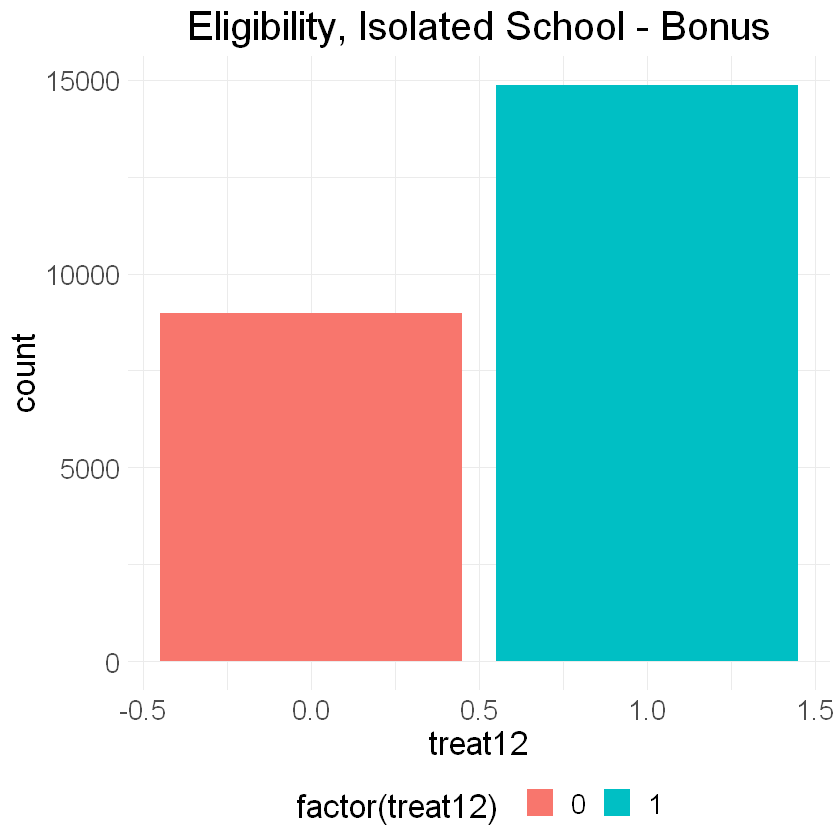

In [11]:
hist_treat12 = ggplot(data, aes(x = treat12, fill = factor(treat12))) +
            geom_bar() + theme_minimal() +
            ggtitle("Eligibility, Isolated School - Bonus") +
            theme(legend.position = "bottom", plot.title = element_text(hjust = 0.5),
                  text = element_text(size = 20))
hist_treat12

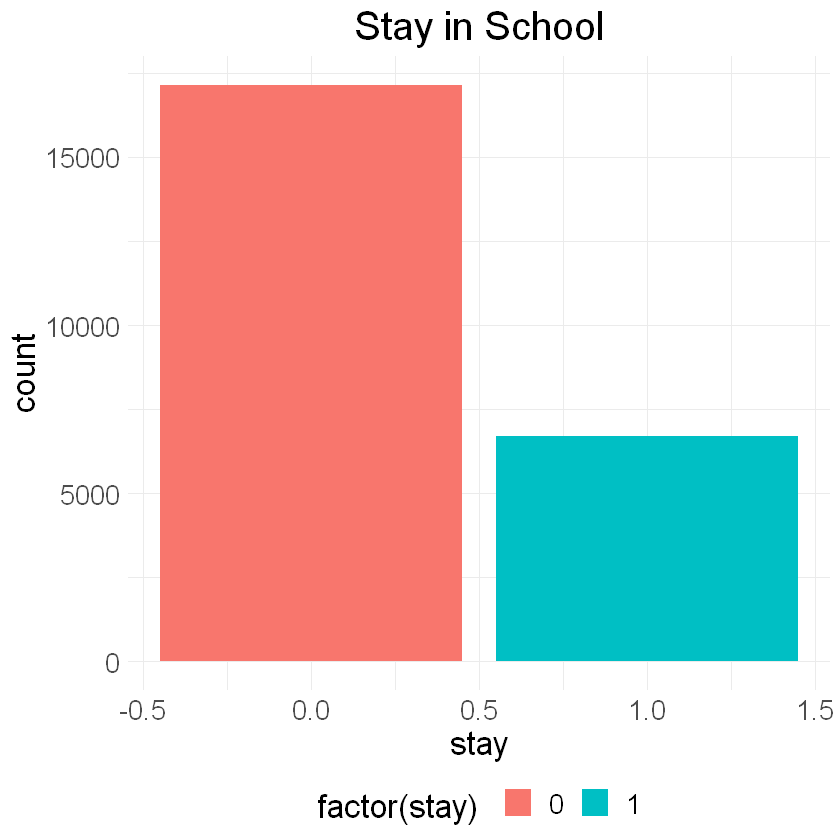

In [12]:
hist_stay = ggplot(data, aes(x = stay, fill = factor(stay))) +
            geom_bar() + theme_minimal() +
            ggtitle("Stay in School") +
            theme(legend.position = "bottom", plot.title = element_text(hjust = 0.5),
                  text = element_text(size = 20))
hist_stay

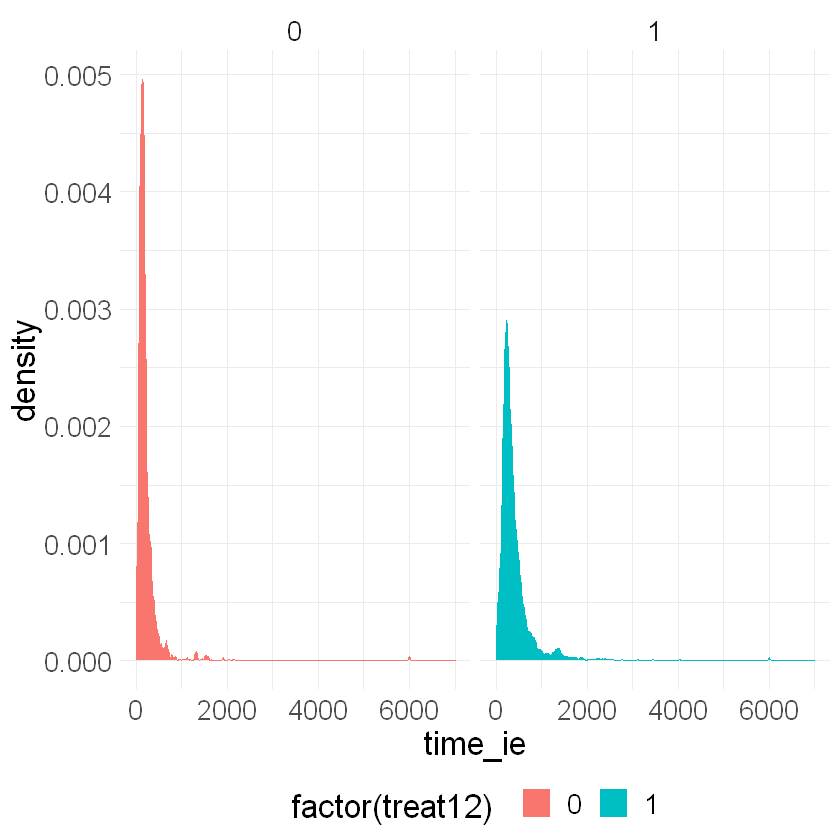

In [13]:
# Eligibility is highly associated with time to traveling and population
dens_time_ie = ggplot(data, aes(x = time_ie, color = factor(treat12), fill = factor(treat12)) ) +
                    geom_density() + xlim(c(0, 7000)) +
                    facet_wrap(.~treat12)  + theme_minimal() +
                    theme(legend.position = "bottom", text = element_text(size = 20))

dens_time_ie

Warning message:
"Removed 10 rows containing non-finite values (stat_density)."


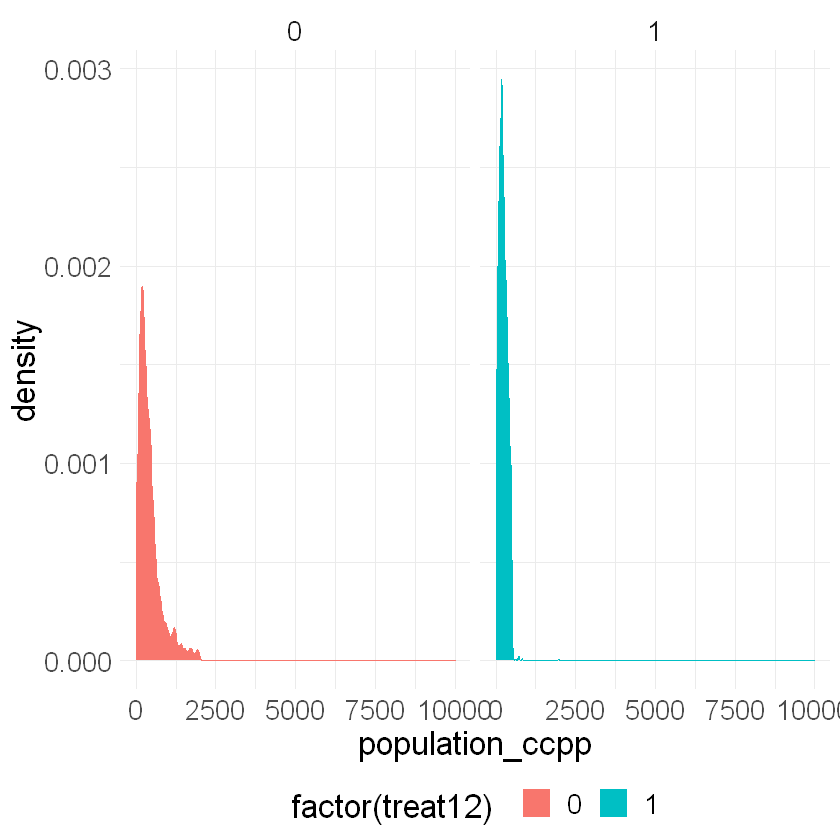

In [14]:
# Eligibility is highly associated with time to traveling and population
dens_population_ccpp = ggplot(data, aes(x = population_ccpp, color = factor(treat12), fill = factor(treat12)) ) +
                    geom_density() + xlim(c(0, 10000)) +
                    facet_wrap(.~treat12)  + theme_minimal() +
                    theme(legend.position = "bottom", text = element_text(size = 20))

dens_population_ccpp

In [15]:
# ATE
outcome <- "stay"
treatment <- "treat12"

Y <- data[,outcome]
W <- data[,treatment]
ate.est <- mean(Y[W==1]) - mean(Y[W==0])
ate.se <- sqrt(var(Y[W == 1]) / sum(W == 1) + var(Y[W == 0]) / sum(W == 0))
ate.tstat <- ate.est / ate.se
ate.pvalue <- 2*(pnorm(1 - abs(ate.est/ate.se)))
ate.results <- c(estimate=ate.est, std.error=ate.se, t.stat=ate.tstat, pvalue=ate.pvalue)
print(ate.results)

    estimate    std.error       t.stat       pvalue 
4.706624e-02 5.922677e-03 7.946784e+00 3.737083e-12 


# DML

In [16]:
# Set up basic model: Specify variables for data-backend
features_base = c("sex", "age", "cpelec", "cpwater", "time_ie", "population_ccpp", 
                "clasification_1", "clasification_2", "clasification_3", 
               "level_1", "level_2", "level_3"  )

# Initialize DoubleMLData (data-backend of DoubleML)
data_dml_base = DoubleMLData$new(data,
                                 y_col = "stay",
                                 d_cols = "treat12",
                                 x_cols = features_base)
data_dml_base

================= DoubleMLData Object ==================


------------------ Data summary      ------------------
Outcome variable: stay
Treatment variable(s): treat12
Covariates: sex, age, cpelec, cpwater, time_ie, population_ccpp, clasification_1, clasification_2, clasification_3, level_1, level_2, level_3
Instrument(s): 
No. Observations: 23856

In [17]:
# Initialize learners
set.seed(123)
lm = lrn("regr.lm")
lm_class = lrn("regr.lm")

# Initialize DoubleMLPLR model
dml_plr_lm = DoubleMLPLR$new(data_dml_base,
                                ml_g = lm,
                                ml_m = lm_class,
                                n_folds = 3)
dbml_lm = dml_plr_lm$fit(store_predictions = TRUE)
dml_plr_lm$summary()

Warning message in predict.lm(object = self$model, newdata = newdata, se.fit = se_fit):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(object = self$model, newdata = newdata, se.fit = se_fit):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(object = self$model, newdata = newdata, se.fit = se_fit):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(object = self$model, newdata = newdata, se.fit = se_fit):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(object = self$model, newdata = newdata, se.fit = se_fit):
"prediction from a rank-deficient fit may be misleading"
Warning message in predict.lm(object = self$model, newdata = newdata, se.fit = se_fit):
"prediction from a rank-deficient fit may be misleading"


Estimates and significance testing of the effect of target variables
        Estimate. Std. Error t value Pr(>|t|)    
treat12  0.044024   0.006271   7.021 2.21e-12 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1




In [18]:
# Initialize learners
set.seed(123)
lasso = lrn("regr.cv_glmnet", nfolds = 5, s = "lambda.min")
lasso_class = lrn("classif.cv_glmnet", nfolds = 5, s = "lambda.min")

# Initialize DoubleMLPLR model
dml_plr_lasso = DoubleMLPLR$new(data_dml_base,
                                ml_g = lasso,
                                ml_m = lasso_class,
                                n_folds = 3)
dbml_lasso = dml_plr_lasso$fit(store_predictions = TRUE)
dml_plr_lasso$summary()

Estimates and significance testing of the effect of target variables
        Estimate. Std. Error t value Pr(>|t|)    
treat12  0.055929   0.007024   7.962 1.69e-15 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1




In [19]:
# Random Forest
randomForest = lrn("regr.ranger", max.depth = 7,
                   mtry = 3, min.node.size = 3)
randomForest_class = lrn("classif.ranger", max.depth = 5,
                         mtry = 4, min.node.size = 7)

set.seed(123)
dml_plr_forest = DoubleMLPLR$new(data_dml_base,
                                 ml_g = randomForest,
                                 ml_m = randomForest_class,
                                 n_folds = 3)
dml_random_forest = dml_plr_forest$fit(store_predictions = TRUE)
dml_plr_forest$summary()

Estimates and significance testing of the effect of target variables
        Estimate. Std. Error t value Pr(>|t|)    
treat12  0.065192   0.008101   8.047 8.46e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1




In [20]:
# Trees
trees = lrn("regr.rpart", cp = 0.0047, minsplit = 203)
trees_class = lrn("classif.rpart", cp = 0.0042, minsplit = 104)

set.seed(123)
dml_plr_tree = DoubleMLPLR$new(data_dml_base,
                               ml_g = trees,
                               ml_m = trees_class,
                               n_folds = 3)
dml_trees = dml_plr_tree$fit(store_predictions = TRUE)
dml_plr_tree$summary()

Estimates and significance testing of the effect of target variables
        Estimate. Std. Error t value Pr(>|t|)    
treat12  0.070930   0.008038   8.824   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1




In [21]:
# Boosted trees
boost = lrn("regr.xgboost",
            objective = "reg:squarederror",
            eta = 0.1, nrounds = 35)
boost_class = lrn("classif.xgboost",
                  objective = "binary:logistic", eval_metric = "logloss",
                  eta = 0.1, nrounds = 34)

set.seed(123)
dml_plr_boost = DoubleMLPLR$new(data_dml_base,
                                ml_g = boost,
                                ml_m = boost_class,
                                n_folds = 3)
dml_boosted_trees = dml_plr_boost$fit(store_predictions = TRUE)
dml_plr_boost$summary()

Estimates and significance testing of the effect of target variables
        Estimate. Std. Error t value Pr(>|t|)    
treat12  0.061065   0.008697   7.022 2.19e-12 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1




In [22]:
mods<- list(dbml_lm, dbml_lasso, dml_random_forest, dml_trees, dml_boosted_trees)

RMSE.mdl<- function(mdl) {
RMSEY <- sqrt(mean(mdl$predictions$ml_g)^2) 
RMSED <- sqrt(mean(mdl$predictions$ml_m)^2) 
return( list(RMSEY=RMSEY, RMSED=RMSED))
}

#RMSE.mdl(DML2.lasso)

#DML2.lasso$ytil

Res<- lapply(mods, RMSE.mdl)


prRes.Y<- c( Res[[1]]$RMSEY,Res[[2]]$RMSEY, Res[[3]]$RMSEY, Res[[4]]$RMSEY, Res[[5]]$RMSEY)
prRes.D<- c( Res[[1]]$RMSED,Res[[2]]$RMSED, Res[[3]]$RMSED, Res[[4]]$RMSED, Res[[5]]$RMSED)

prRes<- rbind(prRes.Y, prRes.D); 
rownames(prRes)<- c("RMSE D", "RMSE Y");
colnames(prRes)<- c("OLS", "Lasso", "Random_Forest", "Trees", "Boosted_Trees")
print(prRes,digit=6)

            OLS    Lasso Random_Forest    Trees Boosted_Trees
RMSE D 0.281427 0.281411      0.281216 0.281139      0.287129
RMSE Y 0.622952 0.623220      0.622981 0.622667      0.619851


In [23]:
# Best method for Y is trees
# Best method for Y is boosted_trees
# Boosted trees
trees = lrn("regr.rpart", cp = 0.0047, minsplit = 203)

boost_class = lrn("classif.xgboost",
                  objective = "binary:logistic", eval_metric = "logloss",
                  eta = 0.1, nrounds = 34)

set.seed(123)
dml_plr_best = DoubleMLPLR$new(data_dml_base,
                                ml_g = trees,
                                ml_m = boost_class,
                                n_folds = 3)
dml_best = dml_plr_best$fit(store_predictions = TRUE)
dml_plr_best$summary()

Estimates and significance testing of the effect of target variables
        Estimate. Std. Error t value Pr(>|t|)    
treat12  0.065366   0.008697   7.515 5.67e-14 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1




## DML using NN

In [54]:
# install.packages("lfe")

In [30]:
library(keras)
library(lfe)


Attaching package: 'lfe'


The following object is masked from 'package:lmtest':

    waldtest




In [31]:
# fixed  <- grep("clasification_", names(data), value=TRUE, fixed=TRUE)

################################ Variables ##################################
#Treatment Variable
d     <- "treat12"

# Outcome Variable
y     <- "stay"

# Other Control Variables
features_base = c("sex", "age", "cpelec", "cpwater", "time_ie", "population_ccpp", 
                "clasification_1", "clasification_2", "clasification_3", 
               "level_1", "level_2", "level_3"  )

#################################  Partial out Fixed Effects ########################

# New Dataset for Partiled-out Variables
rdata  <- as.data.frame(data$stay) 
colnames(rdata) <- "Clasification"

In [32]:
# Variables to be Partialled-out
varlist <- c(y, d, features_base)


# Partial out Variables in varlist from year and county fixed effect
for(i in 1:length(varlist)){
  form <- formula(stay ~ sex + age + 
                        clasification_1 + clasification_2 + clasification_3 +
                        level_1 + level_2 + level_3 +
                        cpelec + cpwater + time_ie + population_ccpp + nlat_ie + nlong_ie)
  rdata[, varlist[i]] <- lm(form, data)$residuals
}

In [72]:
DML2.for.NN <- function(z, d, y, nfold=2, num_epochs, batch_size) {
  nobs <- nrow(z) #number of observations
  foldid <- rep.int(1:nfold,times = ceiling(nobs/nfold))[sample.int(nobs)] #define folds indices
  I <- split(1:nobs, foldid)  #split observation indices into folds  
  ytil <- dtil <- rep(NA, nobs)
  cat("fold: ")
  for(b in 1:length(I)){
    # normalize the data
    mean <- apply(z[-I[[b]],], 2, mean)
    std <- apply(z[-I[[b]],], 2, sd)
    z_nn[-I[[b]],] <- scale(z[-I[[b]],], center = mean, scale = std)
    z_nn[I[[b]],] <- scale(z[I[[b]],], center = mean, scale = std)
    # building the model                    
    build_model <- function(){
        model <- keras_model_sequential() %>% 
        layer_dense(units = 16, activation = "relu", 
                    input_shape = dim(z_nn[-I[[b]],][2]))%>% 
        layer_dense(units = 16, activation = "relu") %>% 
        layer_dense(units = 1) 

        model %>% compile(
        optimizer = "rmsprop", 
        loss = "mse", 
        metrics = c("mae")
        )  
        }
    model.Y <- build_model()
    model.D <- build_model()                       
    # fitting the model                   
    model.D %>% fit(z[-I[[b]],], d[-I[[b]]],
                    epochs = num_epochs, batch_size = batch_size, verbose = 0)                       
    model.Y %>% fit(z[-I[[b]],], y[-I[[b]]],
                    epochs = num_epochs, batch_size = batch_size, verbose = 0)
    dhat <- model.D %>% predict(z[I[[b]],])
    yhat <- model.Y %>% predict(z[I[[b]],])   
    dtil[I[[b]]] <- (d[I[[b]]] - dhat) #record residual for the left-out fold
    ytil[I[[b]]] <- (y[I[[b]]] - yhat) #record residial for the left-out fold                  
    cat(b," ")
    }
  
    rfit <- lm(ytil ~ dtil)    #estimate the main parameter by regressing one residual on the other
    data <- data.frame(cbind(ytil, dtil))
    # rfit <- felm(ytil ~ dtil|0|0|clasification,data=data)
    coef.est <- coef(rfit)[2]  #extract coefficient
    #HC <- vcovHC(rfit)
    se    <- summary(rfit,robust=T)$coefficients[2,2] 
    lower <- confint(rfit)[2,1]
    upper <- confint(rfit)[2,2]
    predict <- predict(rfit)

    cat("coef = ", coef.est , ", se = ", se, 
                ", lower = ", lower, ", upper = ", upper)  #printing output
    
  return( list(coef.est =coef.est , se=se, dtil=dtil, ytil=ytil, rfit=rfit, lower=lower, upper=upper, predict=predict) ) #save output and residuals 
}

In [52]:
# Treatment Variable
D    <- rdata[which(colnames(rdata) == d)]
# Outcome Variable
Y     <- rdata[which(colnames(rdata) == y)]
# Construct matrix Z
Z <- rdata[which(colnames(rdata) %in% c(features_base))]

# inputs
y_nn <- as.matrix(Y)
d_nn <- as.matrix(D)
z_nn <- as.matrix(Z)

In [73]:
#DML with a NN:
set.seed(123)
DML2.nn = DML2.for.NN(z_nn, d_nn, y_nn, nfold=5, 100, 10)

fold: 1  2  3  4  5  coef =  0.5137631 , se =  0.008332326 , lower =  0.4974312 , upper =  0.5300949

ERROR: Error in eval(expr, envir, enclos): objeto 'DML.2.nn' no encontrado


## Results

In [181]:
# Results 
confints = rbind(dml_plr_lm$confint(), dml_plr_lasso$confint(), dml_plr_forest$confint(),
                 dml_plr_tree$confint(), dml_plr_boost$confint(), dml_plr_best$confint())
estimates = c(dml_plr_lm$coef, dml_plr_lasso$coef, dml_plr_forest$coef,
              dml_plr_tree$coef, dml_plr_boost$coef, dml_plr_best$coef)
result_plr = data.table("model" = "PLR",
                        "ML" = c("ols", "glmnet", "ranger", "rpart", "xgboost", "best"),
                        "Estimate" = round(estimates, 4),
                        "lower" = round(confints[,1],4),
                        "upper" = round(confints[,2],4))
# Add the new row
NN <- c("DML", "NN", round(DML2.nn$coef.est[[1]], 4), round(DML2.nn$lower,4), round(DML2.nn$upper,4))
result_plr <- rbind(result_plr, as.list(NN))

result_plr

model,ML,Estimate,lower,upper
<chr>,<chr>,<chr>,<chr>,<chr>
PLR,ols,0.044,0.0317,0.0563
PLR,glmnet,0.0559,0.0422,0.0697
PLR,ranger,0.0652,0.0493,0.0811
PLR,rpart,0.0709,0.0552,0.0867
PLR,xgboost,0.0611,0.044,0.0781
PLR,best,0.0654,0.0483,0.0824
DML,NN,0.5138,0.4974,0.5301


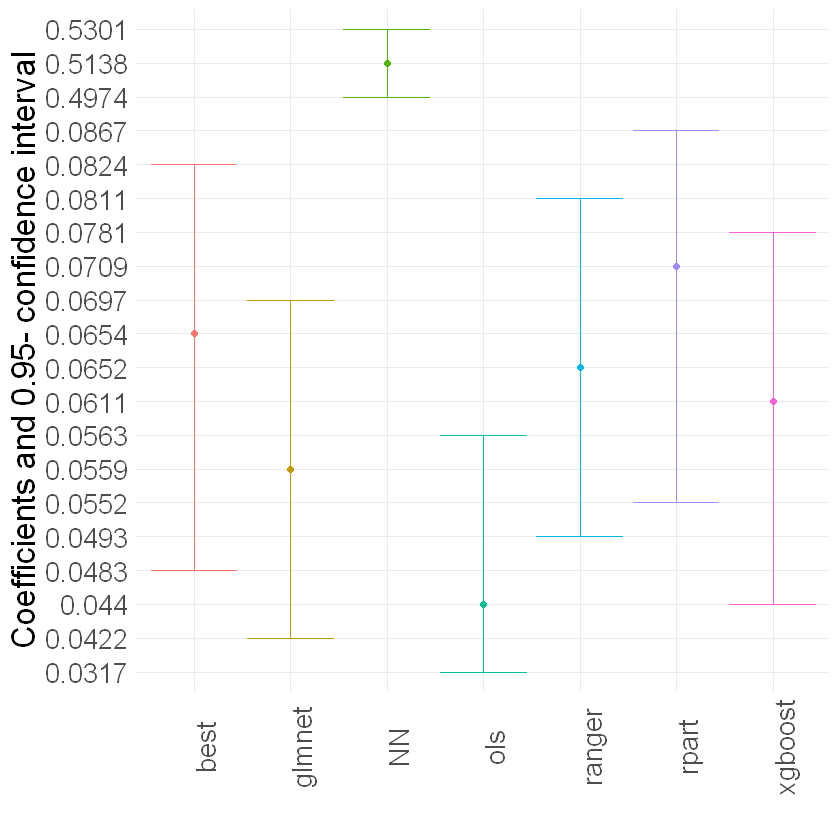

In [182]:
g_ci = ggplot(result_plr, aes(x = ML, y = Estimate, color = ML)) +
        geom_point() +
        geom_errorbar(aes(ymin = lower, ymax = upper, color = ML))  +
        geom_hline(yintercept = 0, color = "grey") +
        theme_minimal() + ylab("Coefficients and 0.95- confidence interval") +
        xlab("") +
        theme(axis.text.x = element_text(angle = 90), legend.position = "none",
              text = element_text(size = 20))

g_ci